# Fine Tuning Transformer for Summary Generation

In [1]:
! pip install transformers -q
! pip install wandb -q
! pip install datasets
! pip install SentencePiece
! pip install nltk
! pip install rouge-score
! pip install evaluate
# Code for TPU packages install

# !curl -q https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 104.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 26.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.4

In [2]:
# Importing stock libraries
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from datasets import load_dataset

# Importing the T5 modules from huggingface/transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration

# WandB – Import the wandb library
import wandb

In [ ]:
# Checking out the GPU we have access to. This is output is from the google colab version.
!nvidia-smi

Mon Oct 16 14:50:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# # Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(f"Device Found : {device}")


Device Found : cuda


In [4]:
# Login to wandb to log the model run and all the parameters
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


### Custom Dataset

In [5]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, dataset, tokenizer, source_max_length, target_max_length):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.source_max_length = source_max_length
        self.target_max_length = target_max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        item = self.dataset[index]

        # Concatenate all columns into a single source_text
        source_text = f"Generate Cover Letter for Role: {item['Job Title']}, Preferred Qualifications: {item['Preferred Qualifications']}, \
                        Hiring Company: {item['Hiring Company']}, User Name: {item['Applicant Name']}, \
                        Past Working Experience: {item['Past Working Experience']}, \
                        Current Working Experience: {item['Current Working Experience']}, \
                        Skillsets: {item['Skillsets']}, Qualifications: {item['Qualifications']}"

        #print("Input Source Row : " , source_text)
        target_text = item['Cover Letter']

        # Tokenize and encode the source and target text
        source_tokens = self.tokenizer.encode_plus(
            source_text,
            max_length=self.source_max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
        )
        target_tokens = self.tokenizer.encode_plus(
            target_text,
            max_length=self.target_max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
        )

        source_ids = source_tokens['input_ids'].squeeze()
        source_mask = source_tokens['attention_mask'].squeeze()
        target_ids = target_tokens['input_ids'].squeeze()
        target_mask = target_tokens['attention_mask'].squeeze()

        return {
            'source_ids': source_ids,
            'source_mask': source_mask,
            'target_ids': target_ids,
            'target_mask': target_mask,
        }


### Train and Validate

In [6]:
# Creating the training function. This will be called in the main function. It is run depending on the epoch value.
# The model is put into train mode and then we wnumerate over the training loader and passed to the defined network


def train(epoch, tokenizer, model, device, loader, optimizer):
    model.train()
    for _,data in enumerate(loader, 0):
        y = data['target_ids'].to(device, dtype = torch.long)
        y_ids = y[:, :-1].contiguous()
        lm_labels = y[:, 1:].clone().detach()
        lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100
        ids = data['source_ids'].to(device, dtype = torch.long)
        mask = data['source_mask'].to(device, dtype = torch.long)

        outputs = model(input_ids = ids, attention_mask = mask, decoder_input_ids=y_ids, labels=lm_labels)
        loss = outputs[0]

        if _%10 == 0:
            wandb.log({"Training Loss": loss.item()})

        if _%500==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # xm.optimizer_step(optimizer)
        # xm.mark_step()

In [25]:
def validate(epoch, tokenizer, model, device, loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for _, data in enumerate(loader, 0):
            y = data['target_ids'].to(device, dtype = torch.long)
            ids = data['source_ids'].to(device, dtype = torch.long)
            mask = data['source_mask'].to(device, dtype = torch.long)

            generated_ids = model.generate(
                input_ids = ids,
                attention_mask = mask,
                max_length=2048,
                num_beams=2,
                repetition_penalty=2.5,
                length_penalty=1.0,
                early_stopping=True
                )
            preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
            target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y]
            if _%100==0:
                print(f'Completed {_}')

            predictions.extend(preds)
            actuals.extend(target)
            #break # Predict for only on record . Remove this break later.
    return predictions, actuals

### Init Training Config

In [8]:

wandb.init(project="transformers_tutorials_summarization")

# WandB – Config is a variable that holds and saves hyperparameters and inputs
# Defining some key variables that will be used later on in the training
config = wandb.config          # Initialize config
config.TRAIN_BATCH_SIZE = 2   # input batch size for training (default: 64)
config.VALID_BATCH_SIZE = 2    # input batch size for testing (default: 1000)
config.TRAIN_EPOCHS = 20        # number of epochs to train (default: 10)
config.VAL_EPOCHS = 1
config.LEARNING_RATE = 0.00001    # learning rate (default: 0.01)
config.SEED = 42               # random seed (default: 42)
config.MAX_LEN = 512
config.COVER_LETTER_MAX_LEN = 1024

# Set random seeds and deterministic pytorch for reproducibility
torch.manual_seed(config.SEED) # pytorch random seed
np.random.seed(config.SEED) # numpy random seed
torch.backends.cudnn.deterministic = True

# tokenzier for encoding the text
tokenizer = T5Tokenizer.from_pretrained("t5-base")

# Download Dataset

dataset = load_dataset("ShashiVish/cover-letter-dataset")
huggingface_train_dataset = dataset['train']
huggingface_test_dataset = dataset['test']



wandb: Currently logged in as: shashi-vish123 (nus-nlp). Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:238: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/813 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/349 [00:00<?, ? examples/s]

In [9]:
train_dataset = CustomDataset(huggingface_train_dataset, tokenizer, config.MAX_LEN, config.COVER_LETTER_MAX_LEN)
test_dataset = CustomDataset(huggingface_test_dataset, tokenizer, config.MAX_LEN, config.COVER_LETTER_MAX_LEN)

# Defining the parameters for creation of dataloaders
train_params = {
    'batch_size': config.TRAIN_BATCH_SIZE,
    'shuffle': True,
    'num_workers': 0
    }

val_params = {
    'batch_size': config.VALID_BATCH_SIZE,
    'shuffle': False,
    'num_workers': 0
    }

# Creation of Dataloaders for testing and validation. This will be used down for training and validation stage for the model.
training_loader = DataLoader(train_dataset, **train_params)
val_loader = DataLoader(test_dataset, **val_params)


# Create Model
#model = T5ForConditionalGeneration.from_pretrained("t5-base")
model = T5ForConditionalGeneration.from_pretrained('ShashiVish/t5-base-fine-tune-1024-cover-letter' , max_length = 2044)
model = model.to(device)

    # # Defining the optimizer that will be used to tune the weights of the network in the training session.
optimizer = torch.optim.Adam(params =  model.parameters(), lr=config.LEARNING_RATE)

# # Log metrics with wandb
wandb.watch(model, log="all")
# # Training loop
print('Initiating Fine-Tuning for the model on our dataset')

Initiating Fine-Tuning for the model on our dataset


### Start Training

In [ ]:
for epoch in range(config.TRAIN_EPOCHS):
  train(epoch, tokenizer, model, device, training_loader, optimizer)


Epoch: 0, Loss:  0.08241504430770874
Epoch: 1, Loss:  0.004798795562237501
Epoch: 2, Loss:  0.014496413990855217
Epoch: 3, Loss:  0.008790938183665276
Epoch: 4, Loss:  0.05865395441651344
Epoch: 5, Loss:  0.0034275345969945192
Epoch: 6, Loss:  0.013736600056290627
Epoch: 7, Loss:  0.037907615303993225
Epoch: 8, Loss:  0.013473153114318848
Epoch: 9, Loss:  0.0348893441259861
Epoch: 10, Loss:  0.03593789413571358
Epoch: 11, Loss:  0.02893223986029625
Epoch: 12, Loss:  0.027901293709874153
Epoch: 13, Loss:  0.023509060963988304
Epoch: 14, Loss:  0.008253908716142178
Epoch: 15, Loss:  0.021031973883509636
Epoch: 16, Loss:  0.021239053457975388
Epoch: 17, Loss:  0.01752234250307083
Epoch: 18, Loss:  0.007270697969943285
Epoch: 19, Loss:  0.020608952268958092


### Upload Model to HuggingFace

In [ ]:
from huggingface_hub import login
login()

In [ ]:
model_path = 't5-base-fine-tune-1024'
# Save Model
model.save_pretrained(model_path)

from huggingface_hub import HfApi
api = HfApi()
api.create_repo(repo_id="t5-base-fine-tune-1024-cover-letter")


api.upload_folder(
    folder_path=model_path,
    repo_id="ShashiVish/t5-base-fine-tune-1024-cover-letter"
)


pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

'https://huggingface.co/ShashiVish/t5-base-fine-tune-1024-cover-letter/tree/main/'

In [ ]:
from transformers import AutoTokenizer
tokenizer.push_to_hub("ShashiVish/t5-base-fine-tune-1024-cover-letter")

CommitInfo(commit_url='https://huggingface.co/ShashiVish/t5-base-fine-tune-1024-cover-letter/commit/7d560a9f1b1861f782cbce5fb83e39967bc97457', commit_message='Upload tokenizer', commit_description='', oid='7d560a9f1b1861f782cbce5fb83e39967bc97457', pr_url=None, pr_revision=None, pr_num=None)

### Download and Evaluate Model

In [22]:

# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

def get_predictions(tokenizer, model, device, val_loader):
  predictions, actuals = validate(1, tokenizer, model, device, val_loader)
  return predictions, actuals


### Calculate Score

In [18]:
import evaluate

def get_accuracy_score(predictions, actuals):
  # Calculate BLEU Score

  bleu = evaluate.load('bleu')
  rouge = evaluate.load('rouge')

  score = {}

  results = rouge.compute(predictions=predictions, references=actuals)
  bleu_results =  bleu.compute(predictions=predictions, references=actuals)

  score['bleu'] = bleu_results['bleu']
  score['rouge1'] = results['rouge1']
  score['rouge2'] = results['rouge2']
  score['rougeL'] = results['rougeL']
  score['rougeLsum'] = results['rougeLsum']

  return score



In [26]:
# Evaluate and generate score
tokenizer = T5Tokenizer.from_pretrained("ShashiVish/t5-base-fine-tune-1024-cover-letter")
model = T5ForConditionalGeneration.from_pretrained('ShashiVish/t5-base-fine-tune-1024-cover-letter' , max_length = 2044)
model = model.to(device)


predictions, actuals = get_predictions(tokenizer, model, device, val_loader)
after_fine_tuning =  get_accuracy_score(predictions, actuals)

print("Final Score After Fine Tunning" , after_fine_tuning)

tokenizer_base = T5Tokenizer.from_pretrained("t5-base")
model_base = T5ForConditionalGeneration.from_pretrained('t5-base' , max_length = 2044)
model_base = model_base.to(device)

predictions, actuals = get_predictions(tokenizer_base, model_base, device, val_loader)
before_fine_tuning =  get_accuracy_score(predictions, actuals)

print("Final Score Before Fine Tunning" , before_fine_tuning)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Completed 0
Completed 100
Final Score After Fine Tunning {'bleu': 0.4758615039897668, 'rouge1': 0.7425759708838753, 'rouge2': 0.6156175488991765, 'rougeL': 0.6427824121095069, 'rougeLsum': 0.6438283149241684}
Completed 0
Completed 100
Final Score Before Fine Tunning {'bleu': 0.06178770620151817, 'rouge1': 0.2777032803391897, 'rouge2': 0.12812388655907128, 'rougeL': 0.19021536111533438, 'rougeLsum': 0.1902335731113}


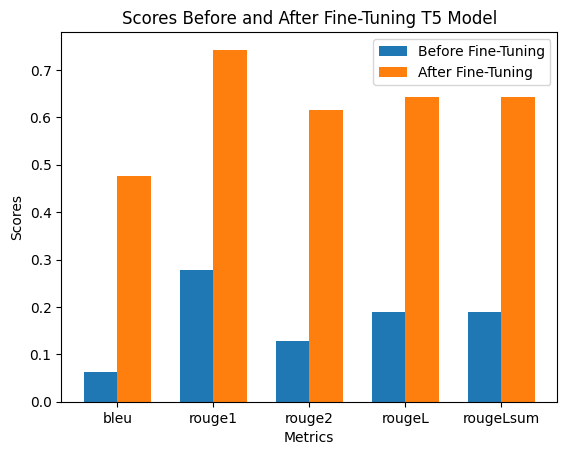

In [28]:
import matplotlib.pyplot as plt

# Metrics and their corresponding scores
metrics = list(before_fine_tuning.keys())
before_scores = list(before_fine_tuning.values())
after_scores = list(after_fine_tuning.values())

# Create a bar chart
fig, ax = plt.subplots()
width = 0.35
x = range(len(metrics))

ax.bar(x, before_scores, width, label='Before Fine-Tuning')
ax.bar([i + width for i in x], after_scores, width, label='After Fine-Tuning')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Scores Before and After Fine-Tuning T5 Model')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(metrics)
ax.legend()

plt.show()


### Predict for Individual Input

In [34]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Load the tokenizer
tokenizer = T5Tokenizer.from_pretrained("ShashiVish/t5-base-fine-tune-1024-cover-letter")
model = T5ForConditionalGeneration.from_pretrained('ShashiVish/t5-base-fine-tune-1024-cover-letter' , max_length = 4096)

# Set the device for inference (CPU or GPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

job_title = "Senior Java Developer"
preferred_qualification = "3+ years of Java, Spring Boot"
hiring_company_name = "Google"
user_name = "Emily Evans"
past_working_experience= "Java Developer at XYZ for 4 years"
current_working_experience = "Senior Java Developer at ABC for 1 year"
skilleset= "Java, Spring Boot, Microservices, SQL, AWS"
qualification = "Master's in Electronics Science"

input_text = f" Generate Cover Letter for Role: {job_title}, \
 Preferred Qualifications: {preferred_qualification}, \
 Hiring Company: {hiring_company_name}, User Name: {user_name}, \
 Past Working Experience: {past_working_experience}, Current Working Experience: {current_working_experience}, \
 Skillsets: {skilleset}, Qualifications: {qualification} "

# Tokenize and generate predictions
input_ids = tokenizer.encode(input_text, return_tensors='pt', max_length=2048, truncation=False, padding=True)
input_ids = input_ids.to(device)
output_ids = model.generate(input_ids)

# Decode the output
output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

print("Generated Cover Letter:")
print(output_text)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Generated Cover Letter:
I am excited to apply for the Senior Java Developer position at Google. I have over three years of experience in Java and Spring Boot and have worked as a Java Developer at XYZ and a Senior Java Developer at ABC. I have a strong understanding of Java, Spring Boot, Microservices, SQL, and AWS. I hold a Master's degree in Electronics Science. I am eager to bring my technical skills and passion for software development to Google.
